In [28]:
#For general simulation usage, use test_simulator. 
#this file only for different simulator with different prediction model
#one time use only, don't reuse this files

In [29]:
import tracesim_header
import tracesim_buffer
import tracesim_network
import tracesim_predictor
import headpred
import train_lstm_headsal
import tracesim_simulate
import tracesim_bandwidth
import tracesim_psnr
import test_simulator_lib

import pickle
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

reload(tracesim_network)
reload(tracesim_buffer)
reload(tracesim_predictor)
reload(tracesim_header)
reload(headpred)
reload(tracesim_simulate)
reload(tracesim_bandwidth)
reload(tracesim_psnr)
reload(test_simulator_lib)

float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [30]:
def create_model_sim(look_ahead):
    print 'CREATE SIM object with look ahead: {}'.format(look_ahead)
    bandwidth, delay = 2000000, 0.2# 8000000, 0.04
    delay = 0.04
    look_back = 8
    tilesize_map_template = './dat/tilesize_map_{}'
    sds_path = '../testing/salient_ds_dict_w16_h9'
    model_lstm_path = './models/lstm_128128_lookahead{}_full_epo2000_ratio0024_sgd'
    bwtrace_path = './4G_log/report_bus_0004.log'
    bwtrace_path = './4G_log/report_bicycle_0001.log'
    bwtrace_path = './3G_log/test1.txt'
    #bwtrace_path = './3G_log/test2.txt'
    sim = tracesim_simulate.Simulator(tilesize_map_template, sds_path, model_lstm_path, look_back, look_ahead, bwtrace_path, delay)
    
    return sim

In [5]:
def run_model_sim(sim, RAD_list, bwscale):

    RAD = 3
    TOPIC = '3'
    UID = 1


    lstm_log = {}
    lnregr_log = {}
    sal_log = {}
    full_log = {}


    sim._bandwidth.set_scale(bwscale)
    for RAD in RAD_list:
        lstm_log[RAD] = []
        lnregr_log[RAD] = []
        sal_log[RAD] = []
        full_log[RAD] = []

        #print 'running for bw{}'.format(bwscale)
        print 'running for rad {}'.format(RAD)

        for TOPIC in ['0', '1']:#['0', '1', '2', '3', '4', '6', '7', '8']:
            bw_bound = sim._pred._tilesize_map_dict[TOPIC][:, :, :, 1].sum()
            for UID in range(1):#range(1, 10):
                print 'running for ', TOPIC, UID
                sim.run(TOPIC, UID, model_name=sim._pred.LSTM, radius=RAD)
                lstm_log[RAD].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                #lstm_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run(TOPIC, UID, model_name=sim._pred.REGR, radius=RAD)
                lnregr_log[RAD].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                  sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                #lnregr_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run(TOPIC, UID, model_name=sim._pred.SAL, radius=RAD)
                sal_log[RAD].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                               sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                #sal_quallog[bwscale] += sim._log[sim._SSIM_LIST]

                sim.run_full(TOPIC, UID)
                full_log[RAD].append([sim._log[sim._STALL_COUNT], sim._log[sim._STALL_TIME] - sim._log[sim._STALL_INIT_TIME], sim._log[sim._STALL_INIT_TIME],\
                                sim._log[sim._BW_USED]*1.0/bw_bound, np.mean(sim._log[sim._ACC_LOG])])
                #full_quallog[bwscale] += sim._log[sim._SSIM_LIST]

        lstm_log[RAD] = np.array(lstm_log[RAD])
        lnregr_log[RAD] = np.array(lnregr_log[RAD])
        sal_log[RAD] = np.array(sal_log[RAD])
        full_log[RAD] = np.array(full_log[RAD])
    return [lstm_log, lnregr_log, sal_log, full_log]

filemark = 'modellog'
for look_ahead in [8, 16, 24, 32]:
    simi = create_model_sim(look_ahead)
    RAD_list = [2, 3, 4, 5]
    radlist_str = '_'.join(map(str, RAD_list))
    bwscale = 5.0
    lstm_log, lnregr_log, sal_log, full_log = run_model_sim(simi, RAD_list, bwscale21)
    loglist = (lstm_log, lnregr_log, sal_log, full_log)
    test_simulator_lib.save_log(loglist,filemark , radlist_str, look_ahead, bwscale)

CREATE SIM object with look ahead: 8
LOADING ./models/lstm_128128_lookahead8_full_epo2000_ratio0024_sgd
(1, 147)
running for rad 2
running for  0 0
running for  1 0
running for rad 3
running for  0 0
running for  1 0
running for rad 4
running for  0 0
running for  1 0
running for rad 5
running for  0 0
running for  1 0
Stall count; stall_time; start_time, bw_used_ratio, non_blank_ratio
[[49.000 14.800 0.350 0.114 0.796]
 [19.000 5.270 0.380 0.055 0.834]]
[[15.000 4.570 0.590 0.118 0.972]
 [3.000 0.620 0.620 0.057 0.987]]
[[25.000 7.440 0.940 0.141 0.995]
 [20.000 4.890 0.960 0.071 1.000]]
[[30.000 18.400 1.140 0.160 1.000]
 [21.000 10.200 1.150 0.087 1.000]]
[[77.000 25.520 0.350 0.142 0.463]
 [35.000 10.660 0.380 0.070 0.712]]
[[48.000 26.290 0.590 0.160 0.693]
 [4.000 2.220 0.620 0.060 0.964]]
[[52.000 44.940 0.940 0.197 0.800]
 [20.000 5.920 0.960 0.074 1.000]]
[[41.000 35.770 1.140 0.186 0.911]
 [21.000 10.140 1.150 0.087 1.000]]
[[81.000 29.630 0.350 0.145 0.421]
 [48.000 17.100 0

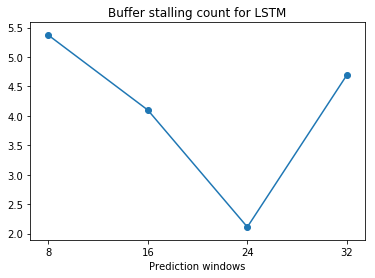

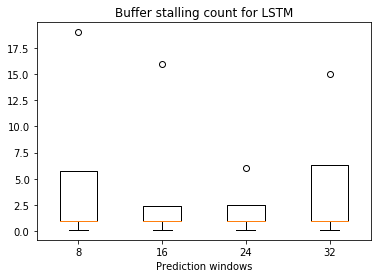

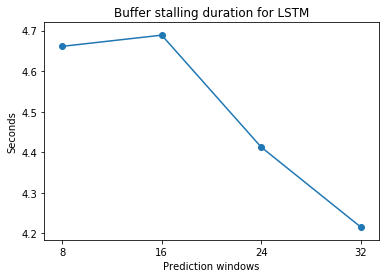

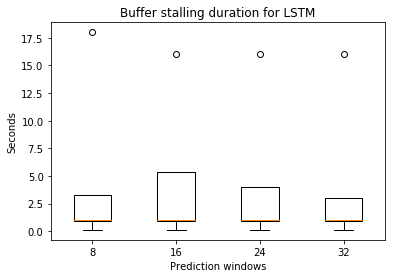

In [37]:
RAD = 4
x = np.arange(4)
x_ticks = np.array([8, 16, 24, 32])
modelname_list = x_ticks
y_list = []
col = 0#stalling count
for look_ahead in x_ticks:
    lstm_log, lnregr_log, sal_log, full_log = pickle.load(open('./result/modellog_rad2_3_4_5_look{}_bwscale_5.0'.format(look_ahead)))
    y_list.append(lstm_log[RAD].T[:, col]) 

plt.figure()
plt.plot([y.mean() for y in y_list])
plt.scatter(x, [y.mean() for y in y_list])
plt.title('Buffer stalling count for LSTM')
plt.xticks(x, x_ticks)
plt.xlabel('Prediction windows')

plt.figure()
plt.boxplot(y_list)
plt.xticks(x+1, x_ticks)
plt.xlabel('Prediction windows')
plt.title('Buffer stalling count for LSTM')

y_list = []
col = 4#stalling count
for look_ahead in x_ticks:
    lstm_log, lnregr_log, sal_log, full_log = pickle.load(open('./result/modellog_rad2_3_4_5_look{}_bwscale_5.0'.format(look_ahead)))
    y_list.append(lstm_log[RAD].T[:, col]) 

plt.figure()
plt.plot([y.mean() for y in y_list])
plt.scatter(x, [y.mean() for y in y_list])
plt.title('Buffer stalling duration for LSTM')
plt.xticks(x, x_ticks)
plt.xlabel('Prediction windows')
plt.ylabel('Seconds')

plt.figure()
plt.boxplot(y_list)
plt.xticks(x+1, x_ticks)
plt.xlabel('Prediction windows')
plt.title('Buffer stalling duration for LSTM')
plt.ylabel('Seconds')

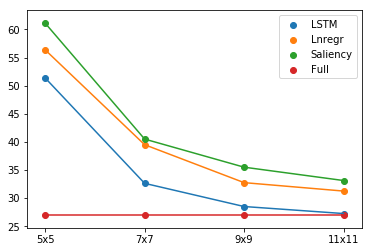

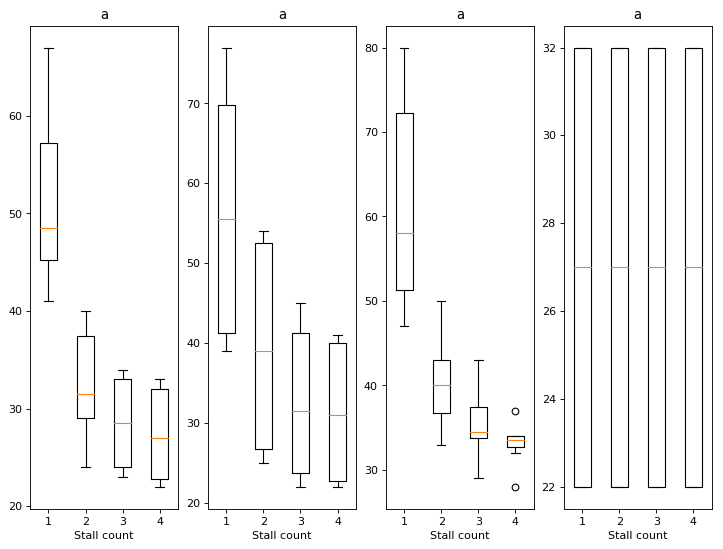

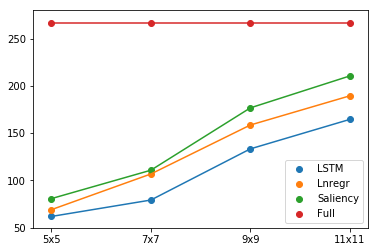

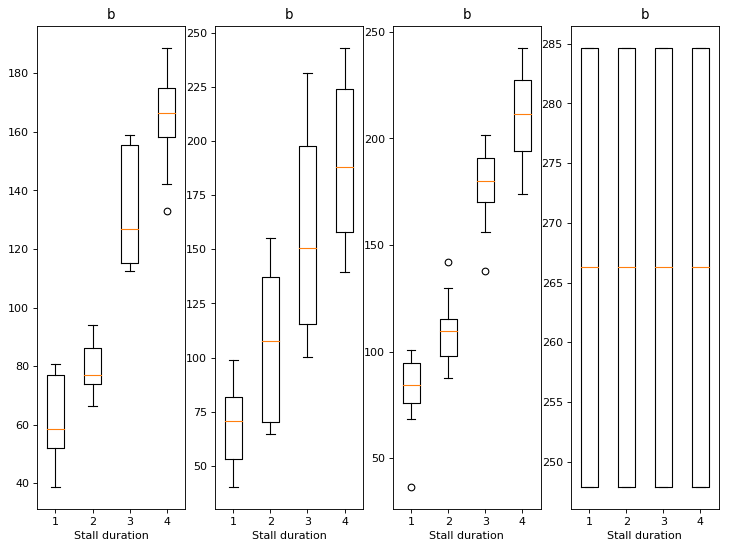

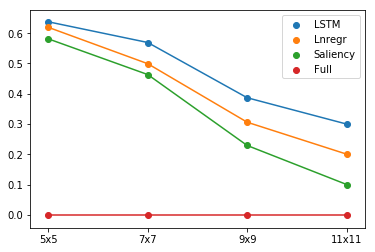

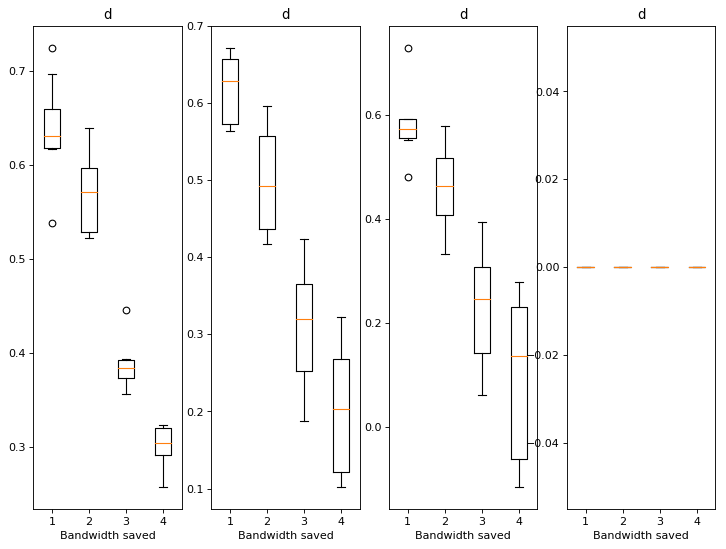

In [19]:
#RESULT for look ahead 32
col_title=['a', 'b', 'c', 'd', 'e']
xlabel_list=['Stall count', 'Stall duration', 'Start time', 'Bandwidth saved', 'Blank ratio']
xticks=['5x5', '7x7', '9x9', '11x11']
x = np.arange(len(xticks))
xlabel='Tile size'
modelname_list = ['LSTM', 'Lnregr', 'Saliency', 'Full']


        
col = 0#showing just the stalling count
y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
test_simulator_lib.plot_log(plt, x, xticks, y_list, modelname_list, title=col_title[col], xlabel=xlabel_list[col], ylabel='' )   

col = 1#showing just the stalling duration
y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
test_simulator_lib.plot_log(plt, x, xticks, y_list, modelname_list, title=col_title[col], xlabel=xlabel_list[col], ylabel='' )  

col = 3#showing just the stalling duration
y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
y_list = 1- y_list / y_list[-1][-1]
test_simulator_lib.plot_log(plt, x, xticks, y_list, modelname_list, title=col_title[col], xlabel=xlabel_list[col], ylabel='' )  

In [ ]:
#RESULT fOR look ahead 24

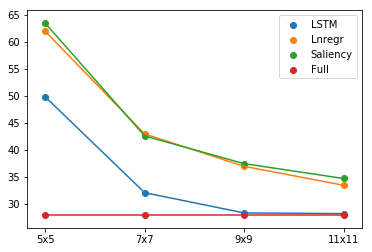

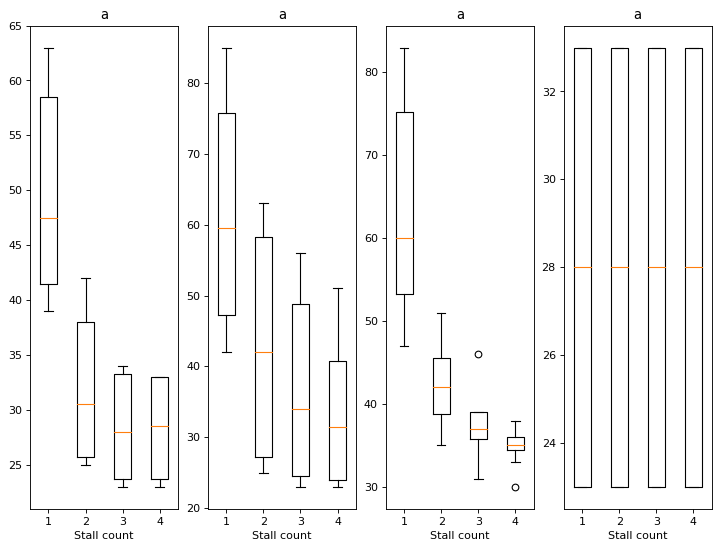

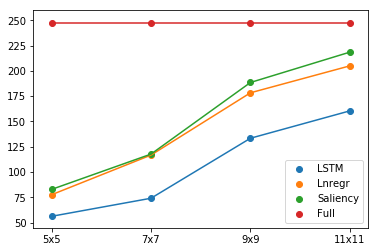

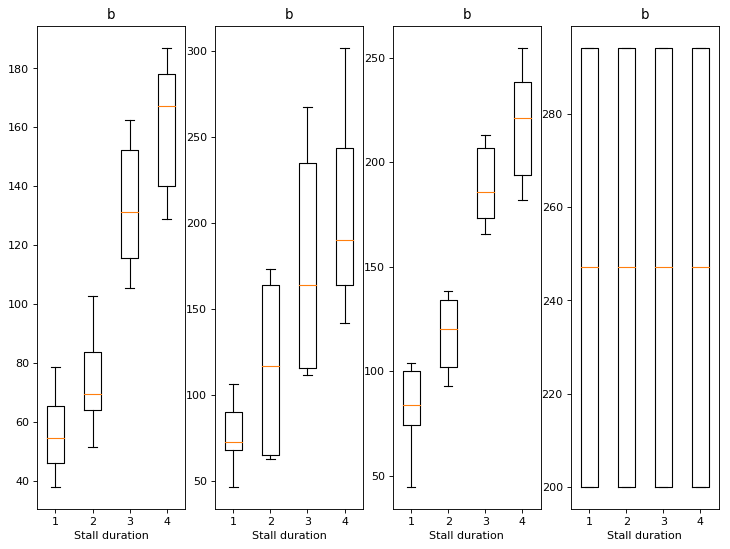

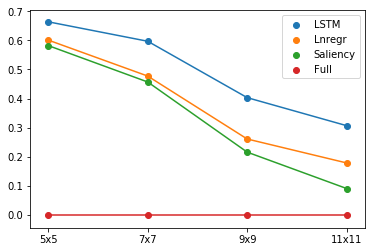

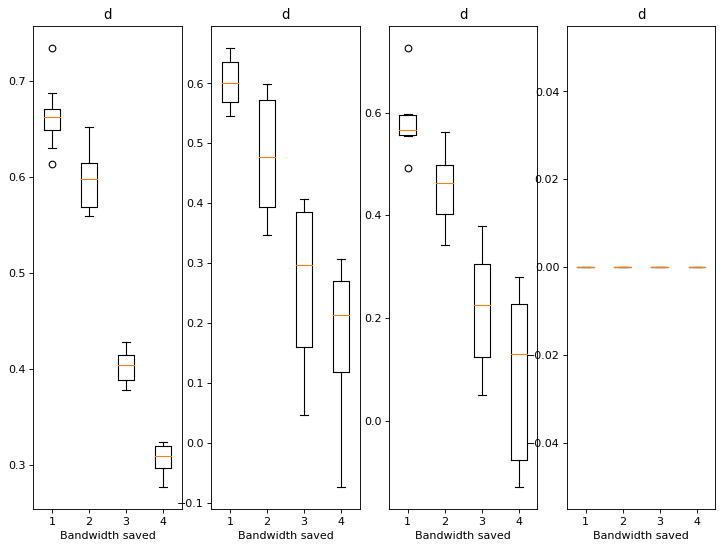

In [ ]:
#result for look ahead =8

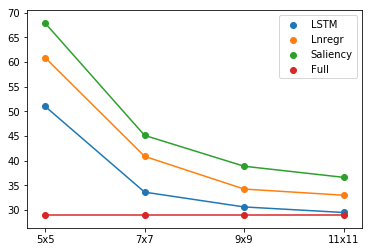

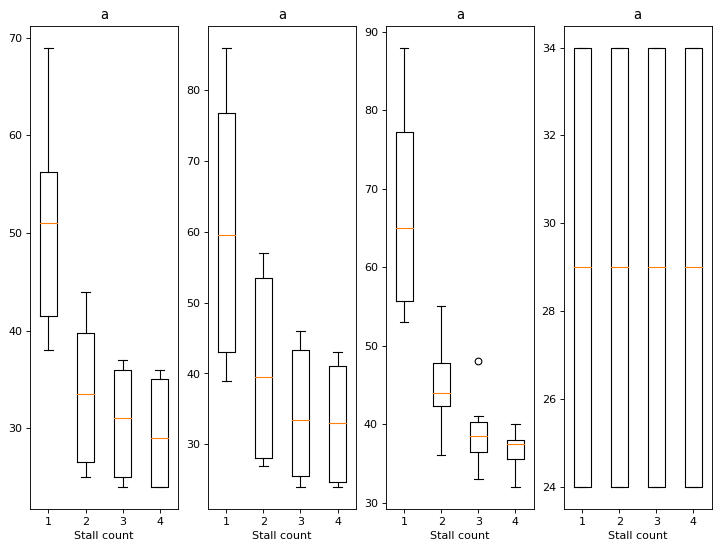

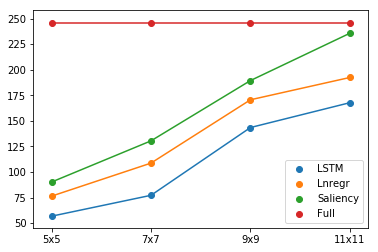

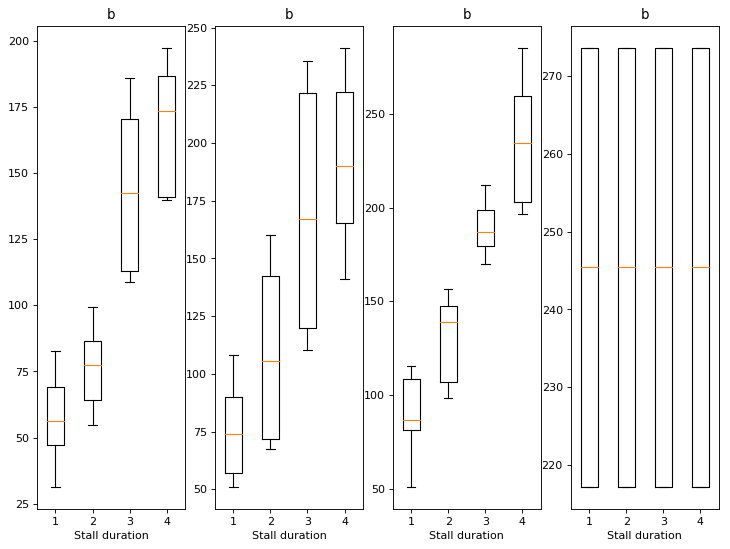

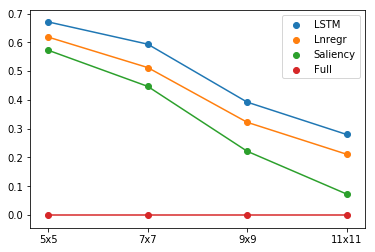

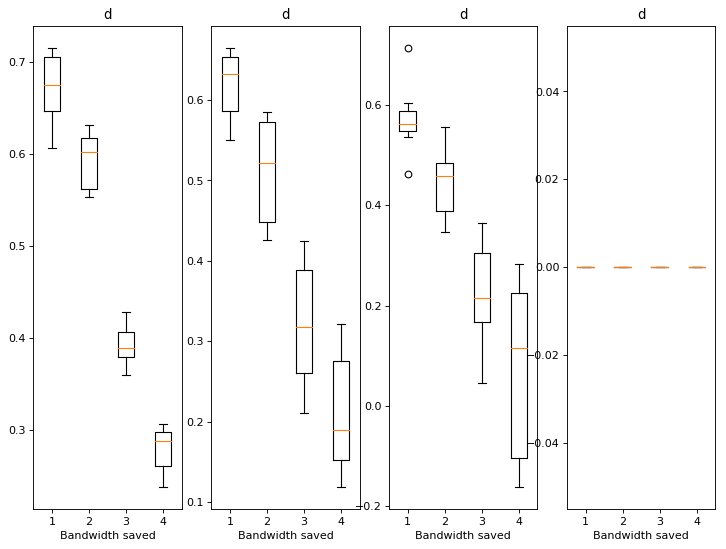

In [ ]:
###RESULT FOR LOOK AHEAD = 16

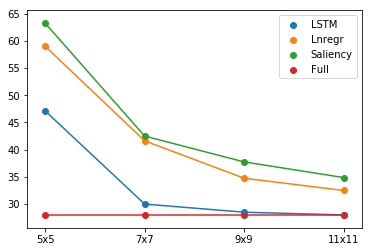

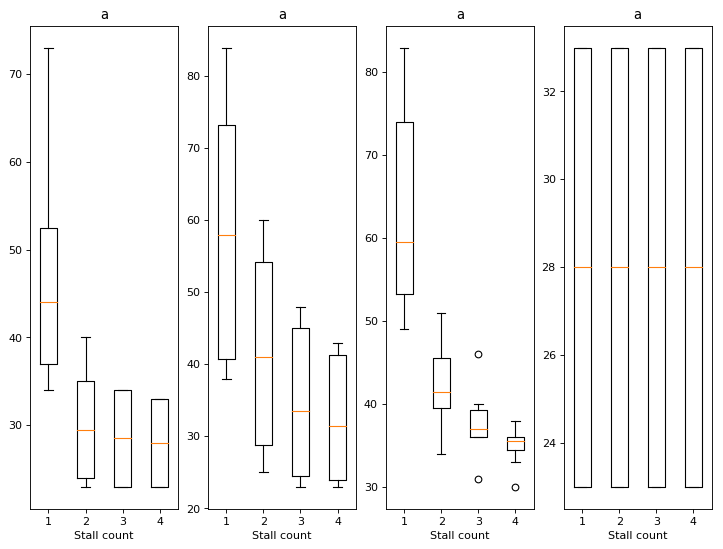

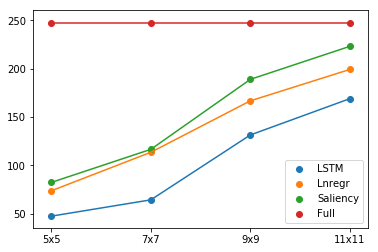

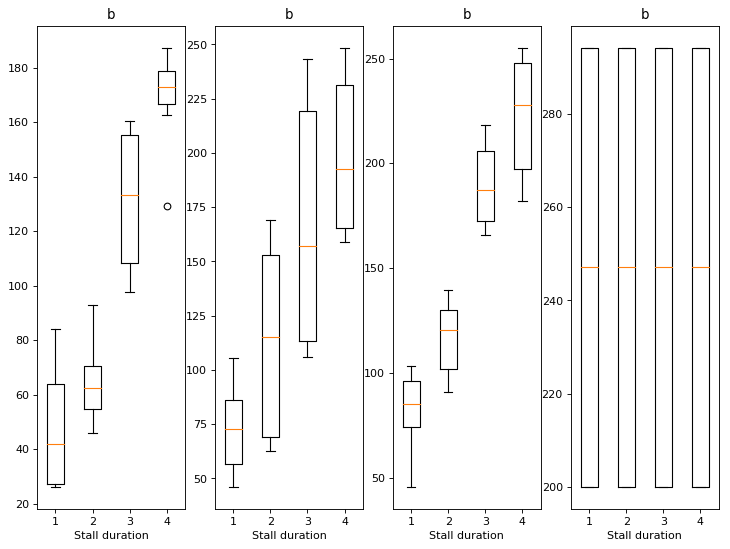

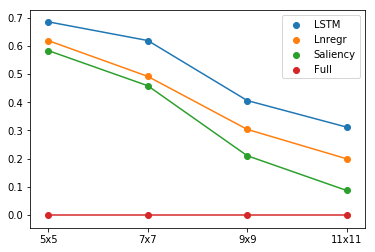

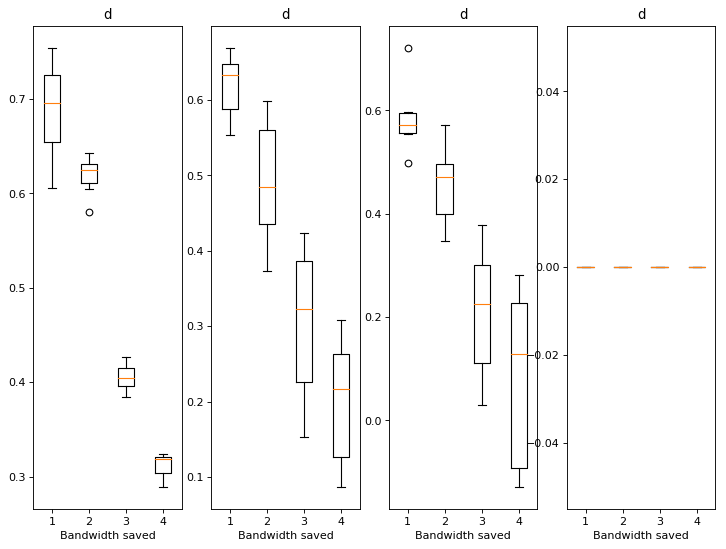